# Teacher Profiles Pt 1 - Definitions

We will review the topic distributions for seeds in this notebook in order to identify typical profiles of teachers. We will begin by importing and identifying the topics, Pt 2 will focus refining this analysis by grouping topics together and reviewing changes in definitions of words & topics. 

***Note that Part 1 needs to be run once for each corpus. Folders containing the materials from each corpus need to be specified.***

In [1]:
import os
import pandas as pd
import numpy as np
import glob 
import visuals as vs
import modeling_tools as mt
import bear_necessities as bn 
from IPython.display import clear_output

from gensim.corpora import Dictionary
from importlib import reload
mt = reload(mt)
vs = reload(vs)

C:\Users\carlo\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\carlo\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Topic Seeds

We want to calculate the distributions of the topic seeds and display it in a way that makes sense. Import the cleaned documents so we can find the frequency of the stemmed seed words in the documents:

In [2]:
# set the corpus range 
rng = '[0, 35)'

# set the cleaning configuration 
dconf = 'A1'

# select the word grouping you would like to use, available are : 'positive','narrow','larger'
wordset = 'narrow'

# no words that occur below nb times or in more than na% of docs 
nb, na = 30, 0.5 

In [6]:
# import the data  
text, stem_map, lemma_map, phrase_frequencies = bn.decompress_pickle(os.getcwd() + '/data/cleaned_data/cleaned_docs_'+dconf+'.pbz2')

*Import Seeds:*

In [4]:
# open seed words for topics 
files = glob.glob(os.getcwd() + '/data/subject_words/'+wordset+'/*.txt')

# get the primary seeds 
primary_seeds = [f for f in files if '_primary' in f]
primary_seeds = mt.extract_seed(primary_seeds)

# and the full seeds 
full_seeds = [f for f in files if '_primary' not in f]
full_seeds = mt.extract_seed(full_seeds)

*Calculate seed frequency:*

In [5]:
mt=reload(mt)
# build a frequency dictionary for all seed words
freq_dict = mt.build_freq_dict(docs, full_seeds, primary_seeds)

# save the seed descriptions
seed_descrpts = mt.seed_descriptions(full_seeds, stem_map)

# return a frequency dataset seeds (returns full seed and primary seed frequencies)
dataframe, dataset = mt.seed_frequencies(docs, full_seeds, freq_dict)

### Managing Frequencies :

We need to identify and manage word frequencies for the words that make up seeds. If all we wanted to do was calculate word frequencies we would be fine, but we also want to identify co-ocurrences thus it will be easier to attach a list of indices to each seed word which can then be handled to return occurence and co-ocurrence ad-hoc. 

*DEFINE RESULTS FOLDER*

In [6]:
rdir = os.getcwd()+'/results/'+wordset+'/'
rdir

'C:\\Users\\carlo\\Dropbox\\Responsibilities\\Teachers_Profiles/results/narrow/'

*Save seed descriptions and frequencies:*

In [7]:
# save the seed descriptions
seed_descrpts.transpose().to_csv(rdir + '/seed_descriptions.csv')

In [8]:
# save the frequencies and descriptions to csv files
#seed_descrpts.to_csv(os.getcwd()+'/results/seed_descriptions'+rng+'.csv')
dataframe.to_csv(rdir + 'seed_frequencies'+rng+'.csv')

### Plot Topic Distribution : 

Lets visualize the topic distributions. In the following graph we display the topics in groups split based on frequency. Notice that the left axis changes as you go down in the graphs. 

*DEFINE GRAPH FOLDER*

In [9]:
gdir = os.getcwd()+'/graphs/'+wordset+'/'

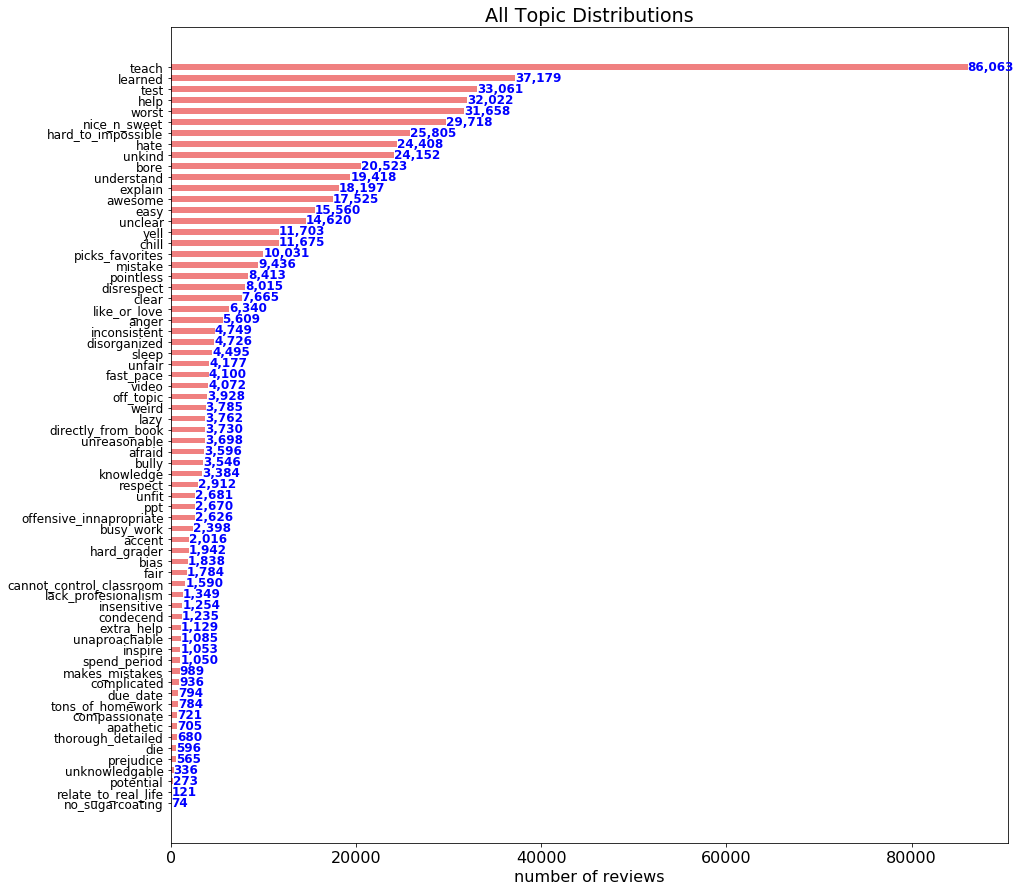

In [21]:
vs=reload(vs)
# set the filepath to save the graph
figure_graph = gdir+'/topic_distributions_hbar_'+rng+'.png'

# how many plots do you want to split the data into 
#num_plots = 4 
#vs.bar_dists(dataframe, num_plots, save=figure_graph)

# sort the data
dataframe = dataframe.sort_values('occurrence', ascending = False)

# horizontal bar chart 
vs.horizontal_barchart(dataframe['seeds'],dataframe['occurrence'],'All Topic Distributions', rot=0)

### Save plots with the words in each topic : 

We can also plot the distribution of words for each topic, these give an idea of what topics are made of. 

In [167]:
vs = reload(vs)

if not os.path.exists(gdir + '/topic_descriptions'):
    os.mkdir(gdir + '/topic_descriptions/')

# save a graph for each topic 
for topic in full_seeds:
    
    # set the graph filename
    graph_name = gdir+'/topic_descriptions/dist '+topic+'.png'
    
    # get the number of occurences for each word in the topic 
    df = {}
    for word in full_seeds[topic]:
        df[word] = len(freq_dict[word]['indices'])
    df = pd.DataFrame(df, index=['# of occurrences']).transpose()
    df.reset_index(inplace=True)
    df = df[df['# of occurrences']>0].rename(columns={'index':'word/phrase'})
    
    # include the total number of times the TOPIC appears (<= sum of appearances of words )
    title = topic + ', total reviews for entire topic : ' + str(len(dataset[topic]['indices']))    

    # create a horizontal bar chart for the number of times each word in each topic occurs
    vs.horizontal_barchart(df['word/phrase'], df['# of occurrences'], title, save=graph_name, fs = 20)

### Topic Co-Occurrence :

Topic co-occurrence will tell us how often one topic pops up in the same review as another.

In [10]:
co_occurrence = {} 
pairs = []
for k in dataset:
    co_occurrence[k] = {}
    search_index = dataset[k]['indices']
    for w in dataset:
        # so we don't repeat elements 
        pair = list(set([w,k]))
        if pair not in pairs:
            pairs.append(pair)        
            if w != k:
                co_occurrence[k][w] = [idx for idx in search_index if idx in dataset[w]['indices']]

In [12]:
bn.compressed_pickle(rdir+'/co_ocurrence_'+rng, co_occurrence)

In [269]:
co_occurrence = bn.decompress_pickle(rdir+'/co_ocurrence_'+rng+'.pbz2')

In [13]:
# quickbuild of co_tp based on co-occurrence 
comat = pd.DataFrame()
for k in dataset:
    crrnce = {} 
    for w in dataset:
        if w!=k:
            try: 
                crrnce[w] = len(co_occurrence[k][w])
            except:
                crrnce[w] = len(co_occurrence[w][k])
    comat = comat.append(pd.DataFrame(crrnce, index = [k]), sort=True)
    
co_tp = comat

# Instance vs. Descriptive Topics 

In this next section we will begin visualizing the interior and exterior of the topic distributions. At this point it is necessary to make a distinction that is key to this analysis: 

* **Event Topics** : these topics are made up of words that describe a specific characteristic, instance or fact about the teacher, class or learning experience in general. Examples include *reading directly from the book* or *not being able to control the clasrroom*.
* **Descriptive Topic** : these topics are made up of word that explain the student's perception of the teacher, a qualitative rating of the experience so to speak. Examples include a teacher being perceived as *hard* or *being hated*.

In the following blocks you can either define which topics are descriptive or perceptual or load a previous categorization.

***Load existing topic categorizations : ***

In [29]:
with open(rdir+'instance_categories.txt','r') as f: instance = f.read()
with open(rdir+'descriptive_categories.txt','r') as f: descriptive = f.read()
instance = list(filter(None, instance.split('\n')))
descriptive = list(filter(None,descriptive.split('\n')))
print("Instance :",instance)
print("Descriptive :",descriptive)

Instance : ['accent', 'afraid', 'anger', 'apathetic', 'bias', 'bore', 'bully', 'busy_work', 'cannot_control_classroom', 'clear', 'compassionate', 'complicated', 'condecend', 'die', 'directly_from_book', 'disorganized', 'disrespect', 'due_date', 'explain', 'extra_help', 'fast_pace', 'fun_or_funny', 'hard_grader', 'help', 'inconsistent', 'insensitive', 'inspire', 'knowledge', 'lack_profesionalism', 'lazy', 'mistake', 'nice_n_sweet', 'no_sugarcoating', 'offensive_innapropriate', 'off_topic', 'picks_favorites', 'pointless', 'potential', 'ppt', 'prejudice', 'relate_to_real_life', 'respect', 'sleep', 'spend_period', 'test', 'thorough_detailed', 'tons_of_homework', 'unaproachable', 'unclear', 'understand', 'unkind', 'unreasonable', 'video', 'weird', 'yell']
Descriptive : ['awesome', 'chill', 'easy', 'fair', 'hard_to_impossible', 'hate', 'learn', 'like_or_love', 'teach', 'unfair', 'unfit', 'worst']


***Decide which topics are descriptive and which are perceptual :***

In [30]:
instance = []
descriptive = [] 
# for each topic
for k in full_seeds.keys(): 
    s= "" # cateogrize it as descriptive or perceptual
    print(k,'- enter "i" for instance, "d" for descriptive: ')
    while (s!="i") & (s!="d"): 
        s = input()
        if s=="i":
            instance+=[k] 
        elif s=="d":
            descriptive+=[k] 
        elif s=="e": # to exit the loop 
            break
        elif s=="c": # skip this topic 
            continue 
        else: # please enter a valid command
            print('please input 1 or 2 to classify the topic.')   
    if s=="e":
        break
    clear_output()
# print out the final categorizations 
print('Instance Categories : ',', '.join([seed for seed in instance]))
print('Descriptive Categories : ',', '.join([seed for seed in descriptive]))
with open(rdir+'instance_categories.txt','w') as f:
    for t in instance: f.write(t + '\n')
    f.close()
with open(rdir+'descriptive_categories.txt','w') as f:
    for t in descriptive: f.write(t + '\n')
    f.close()

Instance Categories :  accent, afraid, anger, apathetic, awesome, bias, bully, busy_work, cannot_control_classroom, chill, clear, compassionate, complicated, condecend, die, directly_from_book, disorganized, disrespect, due_date, explain, extra_help, fair, fast_pace, hard_grader, inconsistent, insensitive, inspire, knowledge, lack_profesionalism, lazy, like_or_love, makes_mistakes, mistake, nice_n_sweet, no_sugarcoating, offensive_innapropriate, off_topic, picks_favorites, pointless, potential, ppt, prejudice, relate_to_real_life, respect, sleep, spend_period, test, thorough_detailed, tons_of_homework, unaproachable, unclear, understand, unfair, unfit, unkind, unknowledgable, unreasonable, video, weird, yell
Descriptive Categories :  bore, easy, hard_to_impossible, hate, help, learned, teach, worst


In [75]:
#instance.remove('awesome')
#descriptive.append('awesome')
print('Instance topics : ', ', '.join(instance))
print('Descriptive topics : ', ', '.join(descriptive))

Instance topics :  accent, afraid, anger, apathetic, bias, bully, busy_work, cannot_control_classroom, chill, clear, compassionate, complicated, condecend, die, directly_from_book, disorganized, disrespect, due_date, explain, extra_help, fair, fast_pace, hard_grader, inconsistent, insensitive, inspire, knowledge, lack_profesionalism, lazy, like_or_love, makes_mistakes, mistake, nice_n_sweet, no_sugarcoating, offensive_innapropriate, off_topic, picks_favorites, pointless, potential, ppt, prejudice, relate_to_real_life, respect, sleep, spend_period, test, thorough_detailed, tons_of_homework, unaproachable, unclear, understand, unfair, unfit, unkind, unknowledgable, unreasonable, video, weird, yell
Descriptive topics :  bore, easy, hard_to_impossible, hate, help, learned, teach, worst, awesome


### Descriptive Topic Co-Occurrence : 

Our intention is to use descriptive topics to evaluate instance categories. However, before doing so we should understand how the descriptive categories co-occur. To do this we use the topic co-occurrence data we created earlier. 

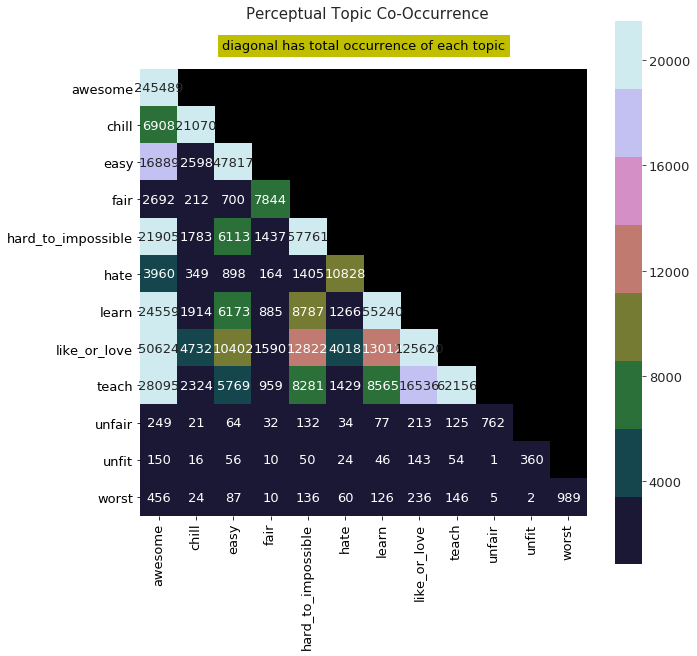

In [90]:
import matplotlib.pyplot as plt 
import seaborn as sns

# get the co-occurrence data only for the perceptual topics 
corr = co_tp.loc[descriptive,descriptive].copy()
mu = corr.mean().mean() # get values from the data to anchor the heatmap color scheme
for p in descriptive: # fill the diagonal axis with the total number of occurrences for each topic
    corr.loc[p,p] = len(dataset[p]['indices'])

corr = corr.fillna(0)

plt.rcParams.update({'font.size': 13})
plt.rcParams['axes.facecolor']='black'
plt.rcParams['figure.facecolor']='white'


dims = (10, 10)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True
fig, ax = plt.subplots(figsize = dims)
with sns.axes_style('whitegrid'):
    sns.heatmap(ax=ax, data=corr, mask=mask, square=True, annot=True,
                 cmap=sns.color_palette("cubehelix", 8), fmt='.0f', vmin = mu/5, vmax=mu*5)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90, ha='center')
    plt.suptitle('Perceptual Topic Co-Occurrence', x=0.44, y=0.9, fontsize=15)
    plt.title('diagonal has total occurrence of each topic', pad = 20, fontsize=13, backgroundcolor='y')
    
fig.savefig(gdir+'Descriptive Topic Co-occurrence.png')

### Descriptions of Each Instance Topic : 

Co-occurrences are dependent on the number of instances recorded for each topic. To see how a certain type of instance is described, we look at how many of its reviews co-occur with a given descriptor. 

In [277]:
vs = reload(vs)

if not os.path.exists(gdir + '/instance_descriptions'):
    os.mkdir(gdir + '/instance_descriptions/')

descr_data = pd.DataFrame()

# for each instance type 
for k in instance: 
    try: 
        # get the co-occurrence data for the graph 
        gd = co_tp[k][descriptive]
        # get the length of the seeds 
        total_topic_reviews = len(dataset[k]['indices'])
        # get the proportion of reviews described in given ways 
        gd = gd/total_topic_reviews
        # graph and save the descriptions for each topic
        graph_name = gdir+'/instance_descriptions/descr_'+str(k)+'.png'
        vs.horizontal_barchart(gd.index, gd.values, k, save=graph_name, dims =(10,10), 
                               afc='linen', ffc='lavender')
        descr_data = descr_data.append(pd.DataFrame(gd).transpose())
    except:
        pass

### Teacher Profiles/Descriptor  Graphs : 

These graphs give a better idea that any other how instances are described by reviewwers. It shows the proportion of each instance that is described by the given descriptive topic, all at once. This allows for an easy comparative analysis of the things that are most likely to land a teacher with a given profile. 

In [283]:
import matplotlib.pyplot as plt
import seaborn as sns

if not os.path.exists(gdir + '/descriptive_distributions'):
    os.mkdir(gdir + '/descriptive_distributions/')

for c in descr_data.columns:
    plt.rcParams['axes.facecolor']='lightblue'
    plt.rcParams['figure.facecolor']='white'

    # create a figure with any number of plots 
    fig, axes = plt.subplots()

    # adjust the spacing of the plots 
    fig.set_size_inches(18, 10)
    fig.suptitle(c)

    # make a barplot of the subdataset 
    gr = sns.barplot(list(descr_data.index),descr_data[c])
    position = 0 
    for idx, row in descr_data.iterrows(): 
        gr.text(position, row[c]*1.01,  '{:,.2f}%'.format(row[c]),color='black',fontsize=14,ha='center')
        position += 1

    plt.xticks(rotation = 90)
    plt.ylabel("proportion of instance reviews with this descriptor")
    plt.xlabel("instance topic")
    
    fig.tight_layout()
    
    plt.savefig(gdir+'/descriptive_distributions/'+str(c)+'.png')
    plt.close(fig)

In [77]:
import matplotlib.pyplot as plt 
import seaborn as sns

for topic in descriptive:
    full_indices = []
    ys = [] 
    tot = len(dataset[topic]['indices'])
    for k in co_tp[co_tp[topic].keys()!=topic][topic].keys():
        try:
            full_indices+=co_occurrence[topic][k]
            ys.append([k,len(co_occurrence[topic][k])/tot])
        except:
            full_indices+=co_occurrence[k][topic]
            ys.append([k,len(co_occurrence[k][topic])/tot])
    full_indices = list(set(full_indices))
    p = len(full_indices)/tot
    label = 'Total Percentage of Reviews Mentioning '+str(topic)+' covered by instances is %.3f' % p

    fig, axes = plt.subplots()
    fig.set_size_inches(18, 10)
    fig.suptitle(label)

    gr = sns.barplot([y[0] for y in ys],[y[1] for y in ys])
    position = 0 
    for y in ys: 
        gr.text(position, y[1]*1.01,  '{:,.1f}%'.format(y[1]*100),color='black',fontsize=14,ha='center')
        position += 1

    plt.xticks(rotation = 90)
    plt.ylabel("proportion of instance reviews with this descriptor")
    plt.xlabel("instance topic")

    fig.tight_layout()
    
    plt.savefig(gdir+'/instance_distributions/'+str(topic)+'.png')
    plt.close(fig)

## Attach Sample Comments 

To get a better idea of how reviewers are using the language we also want to attach sample reviews to each seed.

In [209]:
# we load the full corpus of review texts
text = bn.decompress_pickle(os.getcwd() + '/data/full_review_text.pbz2')

# and the dictionary of indices we want to use
range_indices = bn.loosen(os.getcwd() + '/data/by_rating_range.pickle')

# get the documents pertaining to this range 
reviews = [text[i] for i in range_indices[rng]]

# import list of indices from the cleaning process, clean_index[1] is what you need to pull samples from the reviews object
clean_index = bn.decompress_pickle(os.getcwd() + '/data/cleaned_data/cleaned_index_'+rng+dconf+'.pbz2')  

# import additional review data to attach to the sample comments
data = bn.decompress_pickle(os.getcwd() + '/data/review_stats.pbz2')

## *Pull a random review for any topic or pair of topics :*

In [238]:
import random 

# Comment out one of the two following options.

# 1) co ocurring sample 
#sample = random.sample(co_occurrence['off_topic']['teach'],1)[0]
# 2) or a single topic sample
sample = random.sample(dataset['afraid']['indices'],1)[0]

# NOTE : 
# for range (85-95) and dconf A1  get reviews using clean_index[3]

# To import reviews scroll down to the bottom 
reviews[clean_index[3][558]]

'Mrs. Walls is a great teacher! She is truly trying to help all of us learn history for the AP exam! I am scared of the DBQ though!'

### Save Sample Reviews by Word : 

Get a sample review for each word in all of the topics and save it to a csv. Super easy, a bit time consuming, kind of useful. 

In [ ]:
# import random

# samples = pd.DataFrame()

# for k in freq_dict:
#     sn = 10 
#     sample_reviews = []
#     while len(sample_reviews) == 0: 
#         try:
#             # get the sample reviews 
#             sample_reviews = [reviews[clean_index[1][i]] for i in random.sample(freq_dict[k]['indices'],sn)]
#         except: 
#             sn -= 1 
#             if sn == 0: 
#                 break
            
    
#     # create a dataset with sample reviews 
#     df = pd.DataFrame({"Sample Reviews":sample_reviews})
#     df['Primary'] = ', '.join([p for p in freq_dict[k]['primary'] if freq_dict[k]['primary'][p]])
#     df['Seeds'] = ', '.join(freq_dict[k]['seeds'])
#     df['Word'] = k

#     # format the datasets 
#     df = df.fillna('')
#     df.index = df['Word']
#     df = df.drop('Word',1)
    
#     # append the data
#     samples = samples.append(df)
    
# samples = bn.order(samples,['Primary','Seeds'])
# samples.to_csv(os.getcwd() + '/results/word_sample_reviews.csv')

# Teacher Profiles Pt 2 - Refining 

In this section we will begin by visualizing the definitons of topics (words) and how they change from one corpus to another. This visualization will provide insight as well as a better idea of how we may want to group certain topics together in the profiles created in positive and negative corpus.

In [91]:
# first thing we need to do is import the models we'll be using
from gensim.models.doc2vec import Doc2Vec

# define the selected experimental quality 
moc = 'D2V_A1_D2V5'
corpus_range = '[0, 35)'

model_35 = Doc2Vec.load(os.getcwd()+'/models/'+moc+'/'+moc.replace('D2V_','D2V_'+corpus_range)+'.model')
materials = bn.decompress_pickle(os.getcwd()+'/models/'+moc+'/'+moc.replace('D2V_','materials_'+corpus_range)+'.pbz2')
stem_map_35, lemma_map_35, phrase_freq_35, dictionary_35 = materials

corpus_range = '[85, 95)'

model_95 = Doc2Vec.load(os.getcwd()+'/models/'+moc+'/'+moc.replace('D2V_','D2V_'+corpus_range)+'.model')
materials = bn.decompress_pickle(os.getcwd()+'/models/'+moc+'/'+moc.replace('D2V_','materials_'+corpus_range)+'.pbz2')
stem_map_95, lemma_map_95, phrase_freq_95, dictionary_95 = materials

# Word Similarity Scatter Plots 

A scatter plot that graphs all the words within N degrees of separation by similarity of a given word.

## Getting 2D Projections for Each Dictionary

The reason we get the projection of the entire dictionary instead of the projection of just the subset of words that we're interested in **(the entries library in the following cell block)** is because when we reduce dimensionality using PCA the relative proximity of the subsample of vectors recognize that they are centered around the word(s) you seek to define **(word of the day)** which results in a vector space that minimizes the distances between every other words relative to the distance with the key search words (a graph where the key word is in one corner and the other words are pushed towards the oposite walls). 

A representaiton of the full dictionary preserved the original distances which we can then sample and look at (like zooming into a section of the whole dictionary graph). 

In [92]:
vs = reload(vs)

# get the 2d projections for the dictionaries of each model
projection_35 = vs.project_dictionary(model_35, dictionary_35)
projection_95 = vs.project_dictionary(model_95, dictionary_95)

In [93]:
# we'll also have to retreive the versions of the topics for each corpus 

# open seed words for "positive" topics 
files = glob.glob(os.getcwd()+'/data/subject_words/positive/*.txt')
seeds_positive = [f for f in files if '_primary' not in f]
seeds_positive = mt.extract_seed(seeds_positive)

# open seed words for "narrow" topics 
files = glob.glob(os.getcwd()+'/data/subject_words/narrow/*.txt')
seeds_narrow = [f for f in files if '_primary' not in f]
seeds_narrow = mt.extract_seed(seeds_narrow)

We will use the pyvis module to create network graphs. In order to do this correctly we must first format the data and assign relational weights. 

In [39]:
from importlib import reload
import visuals as vs

In [142]:
vs = reload(vs)

for topic_of_the_day in seeds_positive: 
    db = vs.setup_network_graph(topic_of_the_day, model_95, seeds_positive)
    save = os.getcwd() +'/graphs/positive/topic_definition_networks/'+topic_of_the_day+'.html'
    vs.draw_network_graph(db, save)

C:\Users\carlo\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [95]:
vs = reload(vs)

# graph and save the topics for the positive topics 
for topic_of_the_day in seeds_positive: 
    db = pd.DataFrame()
    for w in seeds_positive[topic_of_the_day]:
        words = vs.add_degrees_of_separation(w, model_95, dos=1)
        df = projection_95[projection_95['Words'].isin(list(words.keys()))]
        df['Degrees']=df['Words'].replace(words)
        db = db.append(df)

    db1 = db.sort_values(['Words','Degrees']).groupby('Words', as_index = False)[['X','Y','Degrees']].first()
    
#     vs.plot_word_similarities(db1, 
#                               title = str(topic_of_the_day)+' - Key Words & Synonyms in 0-35 Corpus', 
#                               save=os.getcwd()+'/graphs/narrow/topic_key_words/'+topic_of_the_day+'.png')

    with open(os.getcwd()+'/graphs/positive/first_synonyms_list/'+str(topic_of_the_day)+'.txt', 'w') as f:
        for w in list(db1.loc[db1['Degrees']==1, 'Words'].values): 
            f.write(w+'\n')
        f.close()

C:\Users\carlo\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
C:\Users\carlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
